<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [4]:
print 'The shape of the data set is ' + str(house.shape)

The shape of the data set is (1460, 81)


In [5]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Goal - We want to identify and remove non-residentials from the dataset.

#####      A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

In [6]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
#drop C in MSZoning
house = house[house.MSZoning != 'C (all)']

In [8]:
print house.columns[house.dtypes == object]
print house.columns[house.dtypes == int]
print house.columns[house.dtypes == float]

Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')
Index([u'Id', u'MSSubClass', u'LotArea', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'BsmtFinSF1', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBat

In [9]:
house.isnull().sum().sort_values(ascending= False)[0:19]

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [10]:
house.shape

(1450, 81)

In [11]:
#adding missing electrica valve with majority value
house.loc[house.Electrical.isnull(),'Electrical'] = 'SBrkr'

In [12]:
#Fill with mean values. LotFrontage missing values with which over 10% of the values are missing. 
house.LotFrontage = house.LotFrontage.fillna(np.mean(house.LotFrontage))

In [13]:
#Fill GarageYrBlt with YearBuilt. Assume that they are built in the same year
house.loc[house['GarageYrBlt'].isnull(), 'GarageYrBlt'] = house[house['GarageYrBlt'].isnull()]['YearBuilt']

#### Missing values can for the features like garage, basements can can be filled with 'none' so they can be used later. 

In [14]:
for col in house.columns[house.isnull().sum() > 0]:
    if house[col].dtype == object:
        house[col] = house[col].fillna("None")
        print house[col].value_counts()

None    1361
Grvl      50
Pave      39
Name: Alley, dtype: int64
None       862
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
TA      639
Gd      618
Ex      121
None     37
Fa       35
Name: BsmtQual, dtype: int64
TA      1303
Gd        65
Fa        43
None      37
Po         2
Name: BsmtCond, dtype: int64
No      947
Av      219
Gd      134
Mn      112
None     38
Name: BsmtExposure, dtype: int64
Unf     424
GLQ     418
ALQ     220
BLQ     147
Rec     130
LwQ      74
None     37
Name: BsmtFinType1, dtype: int64
Unf     1246
Rec       54
LwQ       46
None      38
BLQ       33
ALQ       19
GLQ       14
Name: BsmtFinType2, dtype: int64
None    681
Gd      379
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64
Attchd     870
Detchd     381
BuiltIn     88
None        79
Basment     18
CarPort      8
2Types       6
Name: GarageType, dtype: int64
Unf     600
RFn     419
Fin     352
None     79
Name: GarageFinish, dtype: int64
TA    

In [15]:
#check for remaining missing values
house.isnull().sum().sort_values(ascending= False)[0:5]

MasVnrArea    8
SalePrice     0
Heating       0
RoofStyle     0
RoofMatl      0
dtype: int64

##### MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	   None
       Stone	Stone

MasVnrArea: Masonry veneer area in square feet

In [16]:
#since MasVnrType and MasVnrArea both have 8 missing values, we will assume that there is no Mason
house.loc[house['MasVnrArea'].isnull(), 'MasVnrArea'] = 0

In [17]:
#Check for null value sorted from max to min
house.isnull().sum().sort_values(ascending=False)[0:5]

SalePrice      0
Heating        0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

#### Check 'SalePrice' see if the data indicates any anomalies. We can see here that the 75% and the max values have some huge different. We will investigate that further.

In [18]:
 house['SalePrice'].describe()

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

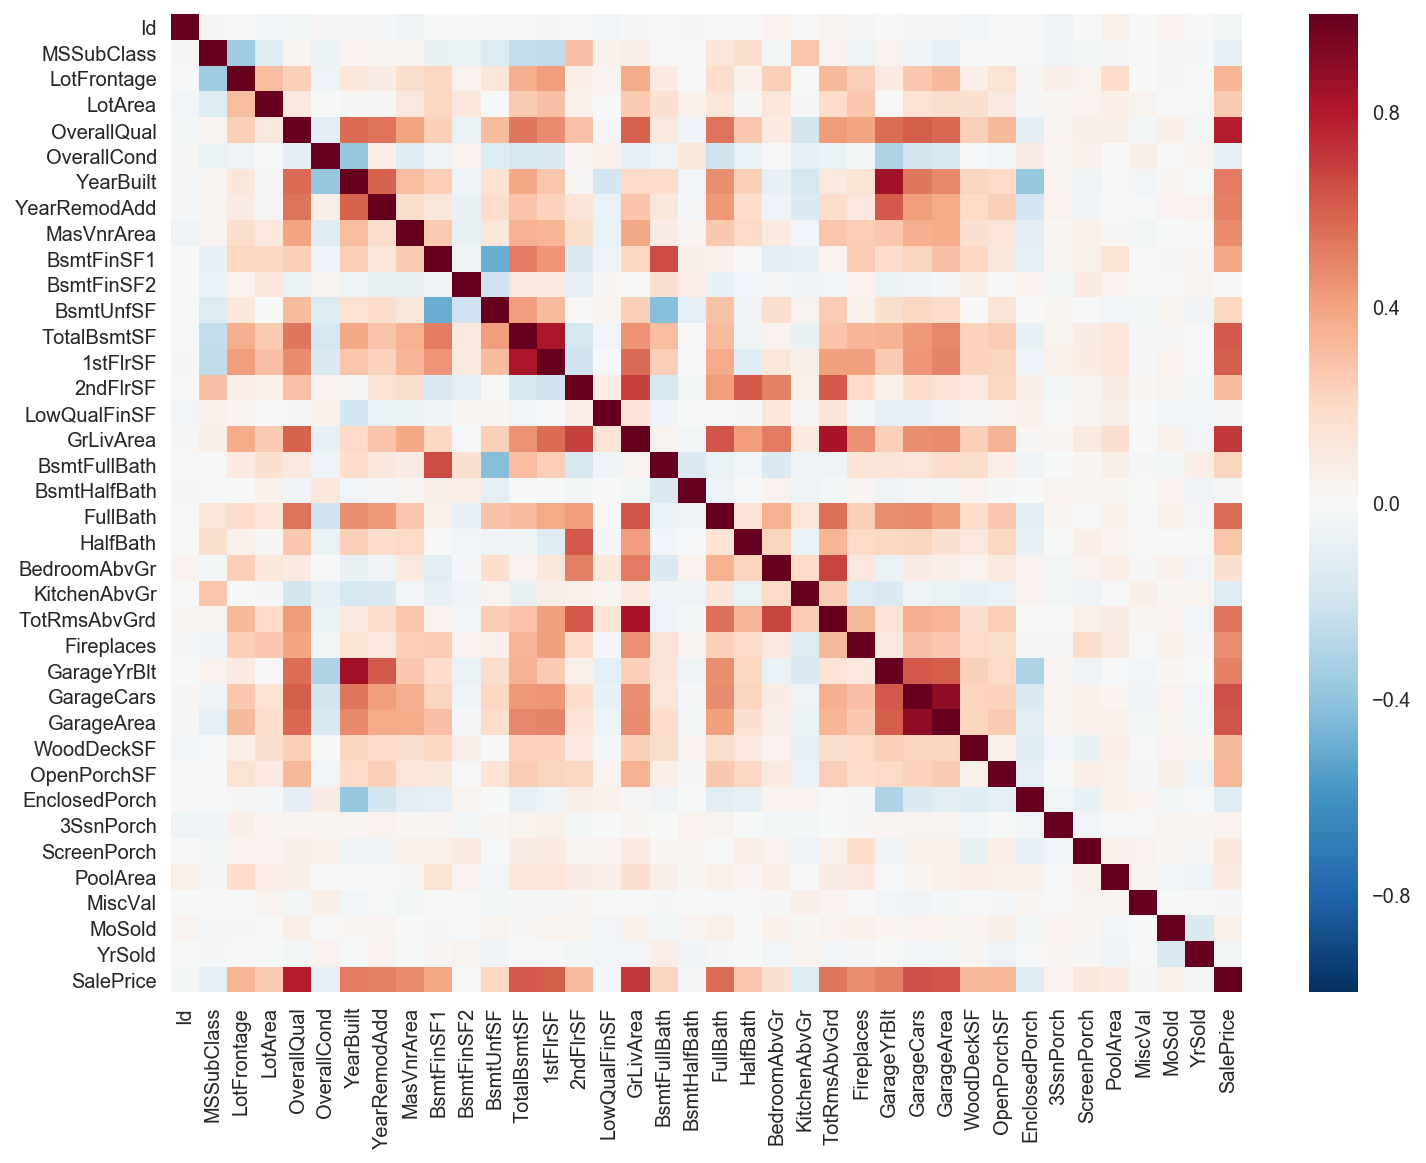

In [19]:
heat_corr = house.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(heat_corr);

#### With the heatmap above, we look for features with high heat intensity which indicates the intensity of the correlation to 'SalePrice'

we like to take a closer look at these features from another visualisation to confirm our analysis. 

#### The pairplot shows us the features' datapoints plotted in correlation to 'SalePrice' . It provides us with a quick overview of the of potential features that might interest us. eg. outliners or correlations that might affect the accuracy of our models in the later part of the analysis.

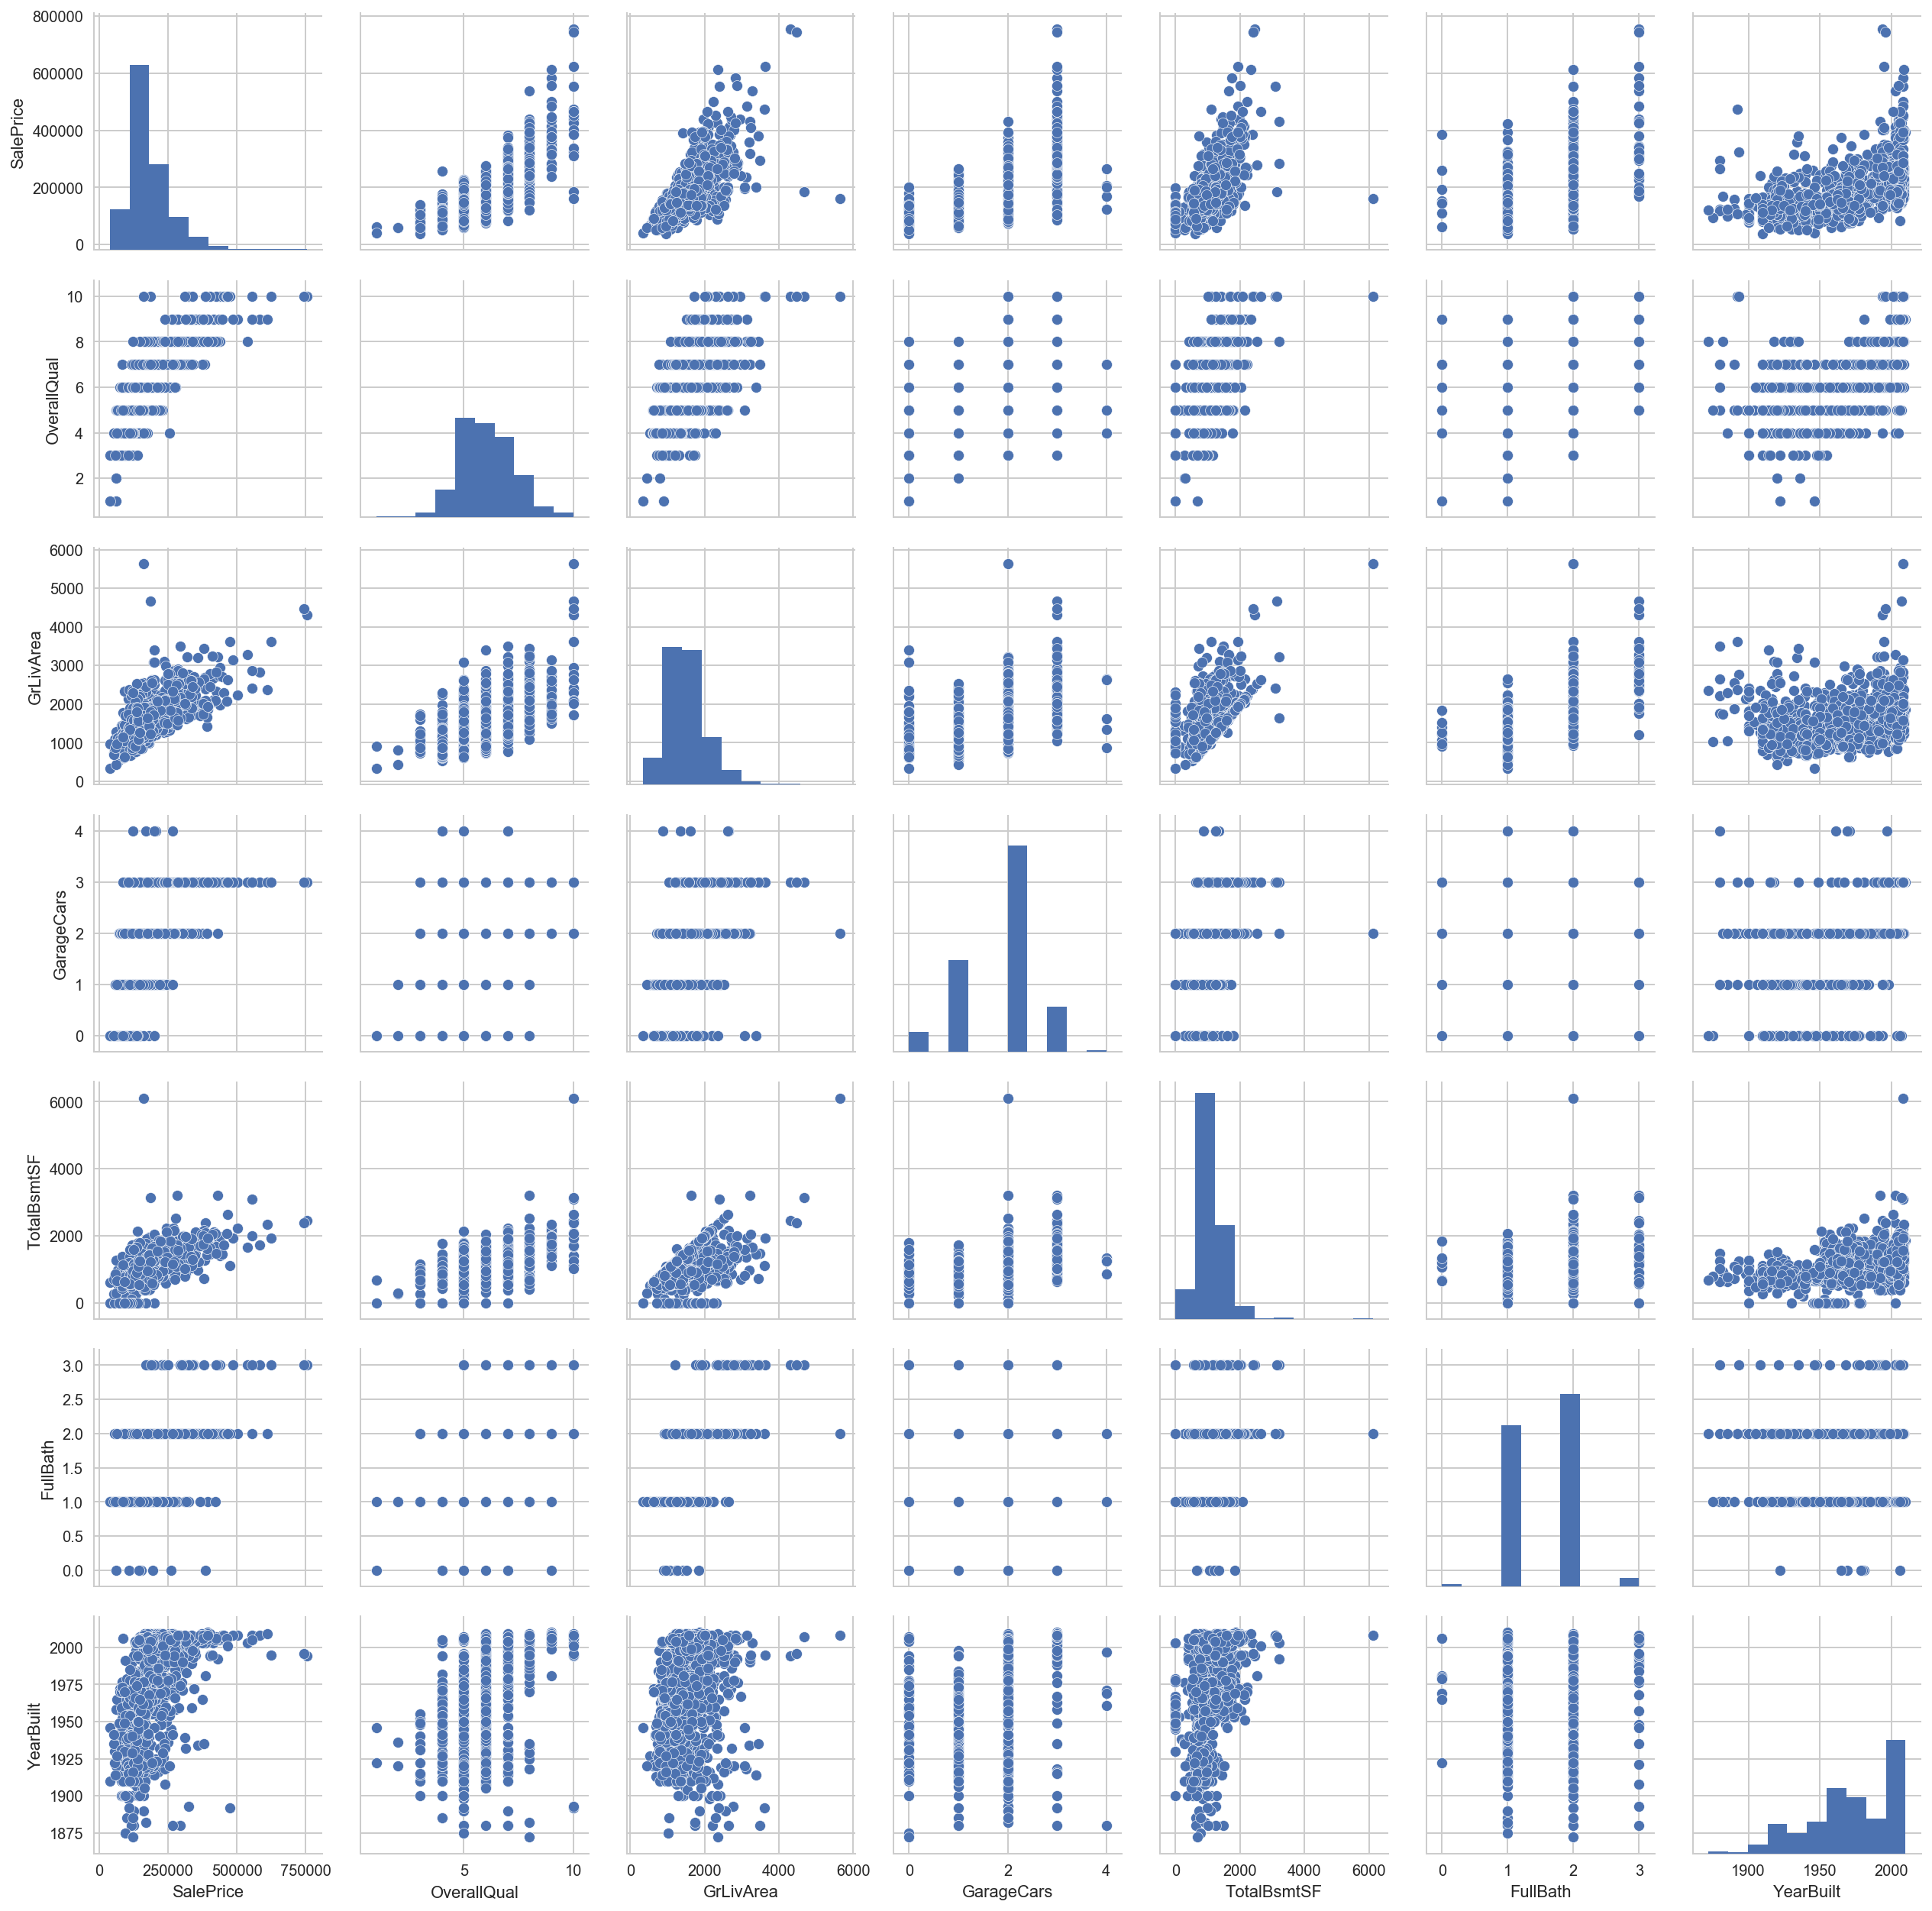

In [20]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

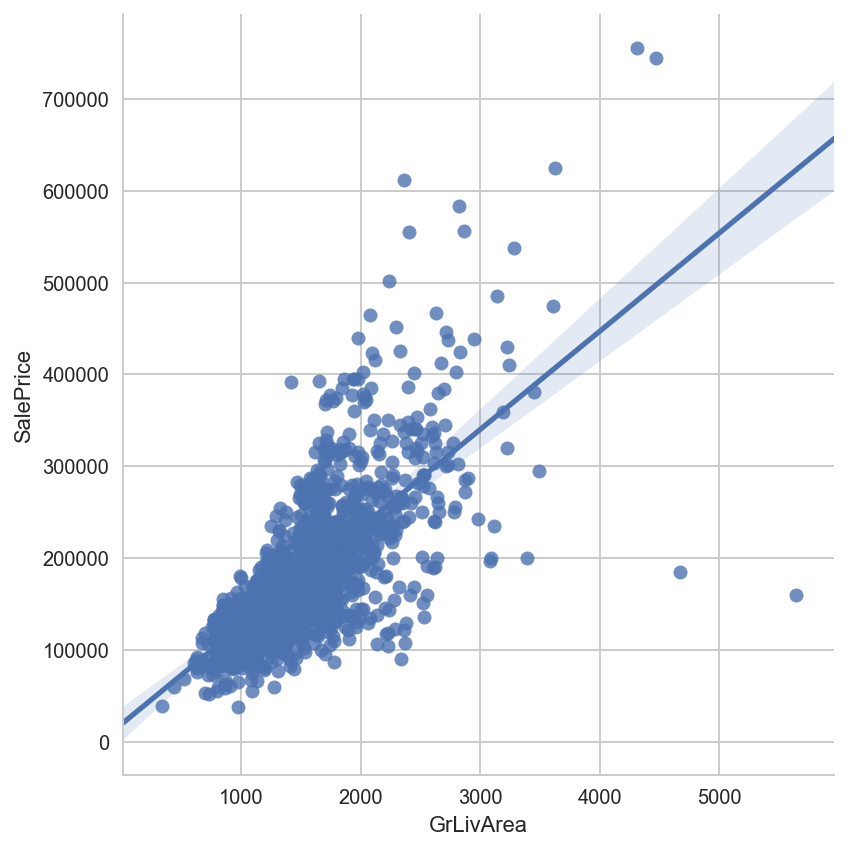

In [21]:
sns.lmplot(x='GrLivArea',y='SalePrice',data=house,fit_reg=True, size=6, palette='day')

In [22]:
#plt.xlabel('GrLivArea')
#plt.ylabel('SalePrice')
#plt.plot(house.GrLivArea,house.SalePrice, 'bo', )         

#### From the plot, it shows that there are 2 outliers with low price and large area. 

We assume that it could be an errorous data entry or there are reason in which the for the 'SalePrice' of the property affected; pattern of the plot suggest that given 'GrLiveArea' of > 4000, it could have a 'SalePrice' > ~460,000.

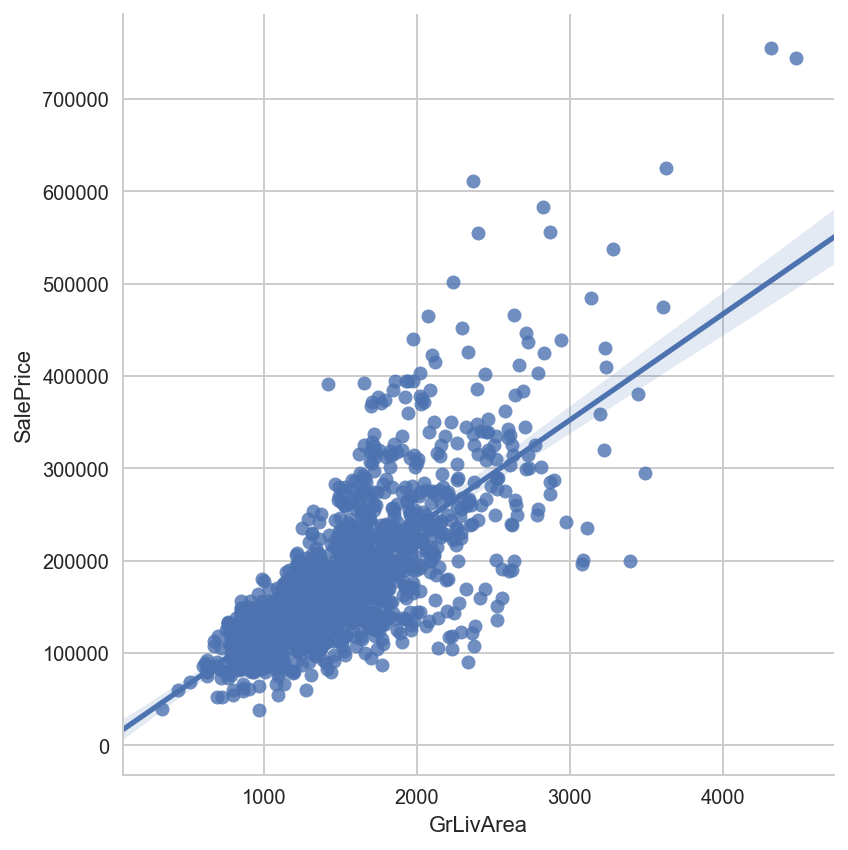

In [23]:
##removed by trial and error
house = house[house.GrLivArea < 4650]
sns.lmplot(x='GrLivArea',y='SalePrice',data=house,fit_reg=True, size=6, palette='day')

In [24]:
#house = house[house.GrLivArea < 4650]
#plt.xlabel('GrLivArea')
#plt.ylabel('SalePrice')
#plt.plot(house.GrLivArea,house.SalePrice, 'bo')

#### On examination of the plot of 'TotalBsmtSF' vs 'SalePrice', we see a number of data points reflecting 0 'TotalBsmtSF' but selling for a range of price. This is likely the fact that these are residential apartments.

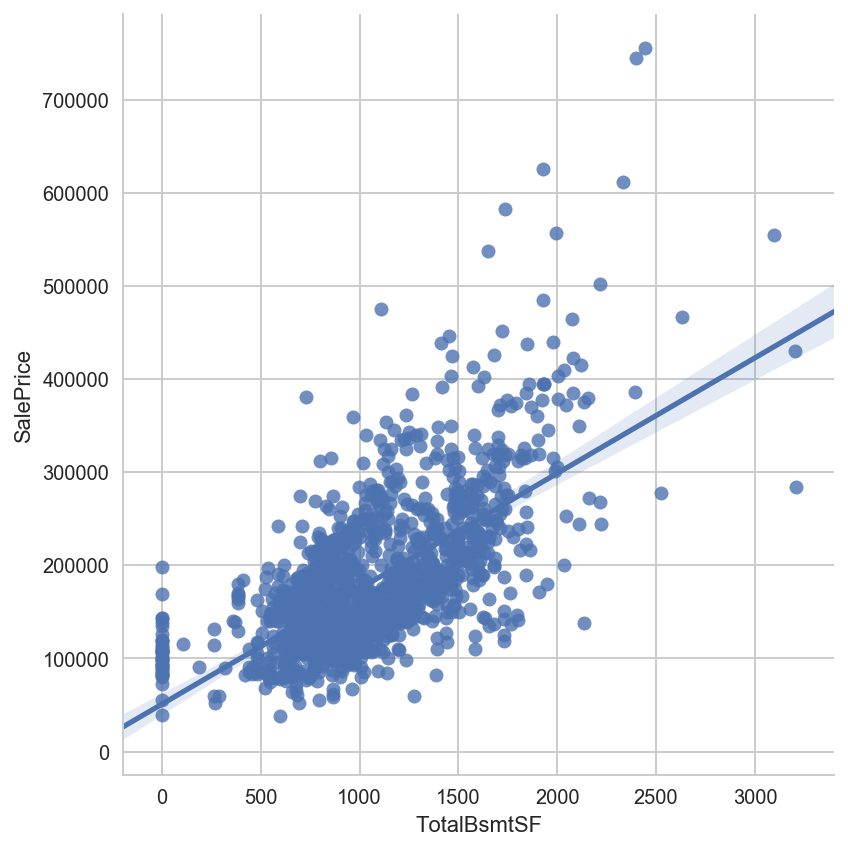

In [25]:
sns.lmplot(x='TotalBsmtSF',y='SalePrice',data=house,fit_reg=True, size=6, palette='day')

In [26]:
#plt.xlabel('TotalBsmtSF')
#plt.ylabel('SalePrice')
#plt.plot(house.TotalBsmtSF,house.SalePrice,'bo')

In [27]:
house.rename(index=str, columns={'1stFlrSF':'FirstFlrSF', '2ndFlrSF':'SecFlrSF', '3SsnPorch':'ThreeSsnPorch'},inplace=True)
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'FirstFlrSF',
       u'SecFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish

In [28]:
#identifying data points and preparing for split. > 2010 test, <2010 train
house.YrSold.value_counts()

2009    336
2007    327
2006    312
2008    301
2010    172
Name: YrSold, dtype: int64

In [29]:
#to check and sort values
house = house.sort_values('YrSold')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1272,1273,20,RL,70.052897,13526,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,None,0,11,2006,WD,Normal,137000
525,526,20,FV,62.000000,7500,Pave,Pave,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2006,WD,Normal,176000
831,832,160,FV,30.000000,3180,Pave,Pave,Reg,Lvl,AllPub,...,0,None,None,None,0,6,2006,WD,Normal,151000
270,271,60,FV,84.000000,10728,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2006,New,Partial,266000
693,694,30,RL,60.000000,5400,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,12,2006,WD,Abnorml,108480


In [30]:
#Resetting index before splitting into training and test set
house = house.reset_index(drop=True)
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1273,20,RL,70.052897,13526,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,None,0,11,2006,WD,Normal,137000
1,526,20,FV,62.000000,7500,Pave,Pave,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2006,WD,Normal,176000
2,832,160,FV,30.000000,3180,Pave,Pave,Reg,Lvl,AllPub,...,0,None,None,None,0,6,2006,WD,Normal,151000
3,271,60,FV,84.000000,10728,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2006,New,Partial,266000
4,694,30,RL,60.000000,5400,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,12,2006,WD,Abnorml,108480


In [31]:
house_index = house.Id

You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:

The neighborhood
Square feet
Bedrooms, bathrooms
Basement and garage space
and many more.

Some examples of things that ARE renovate-able:
Roof and exterior features
"Quality" metrics, such as kitchen quality
"Condition" metrics, such as condition of garage
Heating and electrical components

In [32]:
reno = ['Utilities','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd','ExterCond', 'Street' \
        ,'Alley','MasVnrType','Foundation', 'Heating','Electrical', 'PavedDrive', 'Fence'\
        ,'MiscFeature']
fixed = house.drop(reno, axis=1)
fixed.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,ThreeSsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1273,20,RL,70.052897,13526,IR1,Lvl,CulDSac,Gtl,Sawyer,...,0,0,0,None,0,11,2006,WD,Normal,137000
1,526,20,FV,62.000000,7500,Reg,Lvl,Inside,Gtl,Somerst,...,0,0,0,None,0,4,2006,WD,Normal,176000
2,832,160,FV,30.000000,3180,Reg,Lvl,Inside,Gtl,Somerst,...,0,0,0,None,0,6,2006,WD,Normal,151000
3,271,60,FV,84.000000,10728,Reg,Lvl,Inside,Gtl,Somerst,...,0,0,0,None,0,8,2006,New,Partial,266000
4,694,30,RL,60.000000,5400,Reg,Lvl,Corner,Sev,OldTown,...,0,0,0,None,0,12,2006,WD,Abnorml,108480


In [33]:
reno_df = house[reno]
reno_df.head()

,Utilities,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterCond,Street,Alley,MasVnrType,Foundation,Heating,Electrical,PavedDrive,Fence,MiscFeature
0,AllPub,Hip,CompShg,HdBoard,Plywood,TA,Pave,None,BrkFace,CBlock,GasA,SBrkr,Y,MnPrv,None
1,AllPub,Gable,CompShg,VinylSd,VinylSd,TA,Pave,Pave,None,PConc,GasA,SBrkr,Y,None,None
2,AllPub,Gable,CompShg,MetalSd,MetalSd,TA,Pave,Pave,None,PConc,GasA,SBrkr,Y,None,None
3,AllPub,Gable,CompShg,VinylSd,VinylSd,TA,Pave,None,None,PConc,GasA,SBrkr,Y,None,None
4,AllPub,Gable,CompShg,MetalSd,MetalSd,TA,Pave,None,None,BrkTil,GasA,SBrkr,Y,None,None


In [34]:
feature = 'SalePrice ~' + ' + '. join ([c for c in fixed.columns if not c=='SalePrice'])
feature

'SalePrice ~Id + MSSubClass + MSZoning + LotFrontage + LotArea + LotShape + LandContour + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + OverallQual + OverallCond + YearBuilt + YearRemodAdd + MasVnrArea + ExterQual + BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinSF1 + BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + HeatingQC + CentralAir + FirstFlrSF + SecFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Functional + Fireplaces + FireplaceQu + GarageType + GarageYrBlt + GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + PoolQC + MiscVal + MoSold + YrSold + SaleType + SaleCondition'

In [35]:
import patsy

y,X = patsy.dmatrices (feature, data=fixed, return_type ="dataframe")
y=y.values.ravel()

In [36]:
X.shape

(1448, 184)

In [37]:
y.shape

(1448,)

In [38]:
print np.mean(y)

181667.759669


In [39]:
#setup training set
X_train = X[X['YrSold'] != 2010]
y_train = y[X['YrSold'] != 2010]

#setup test set
X_test = X[X['YrSold'] == 2010]
y_test = y[X['YrSold'] == 2010]

print X_train.shape, y_train.shape, X_train.shape, y_test.shape

(1276, 184) (1276,) (1276, 184) (172,)


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit (X_train)
Xs = scaler.transform(X_train)
Xt = scaler.transform(X_test)

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(Xs,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
#Generating ˆy, using X test values
pred = lr.predict(Xt)

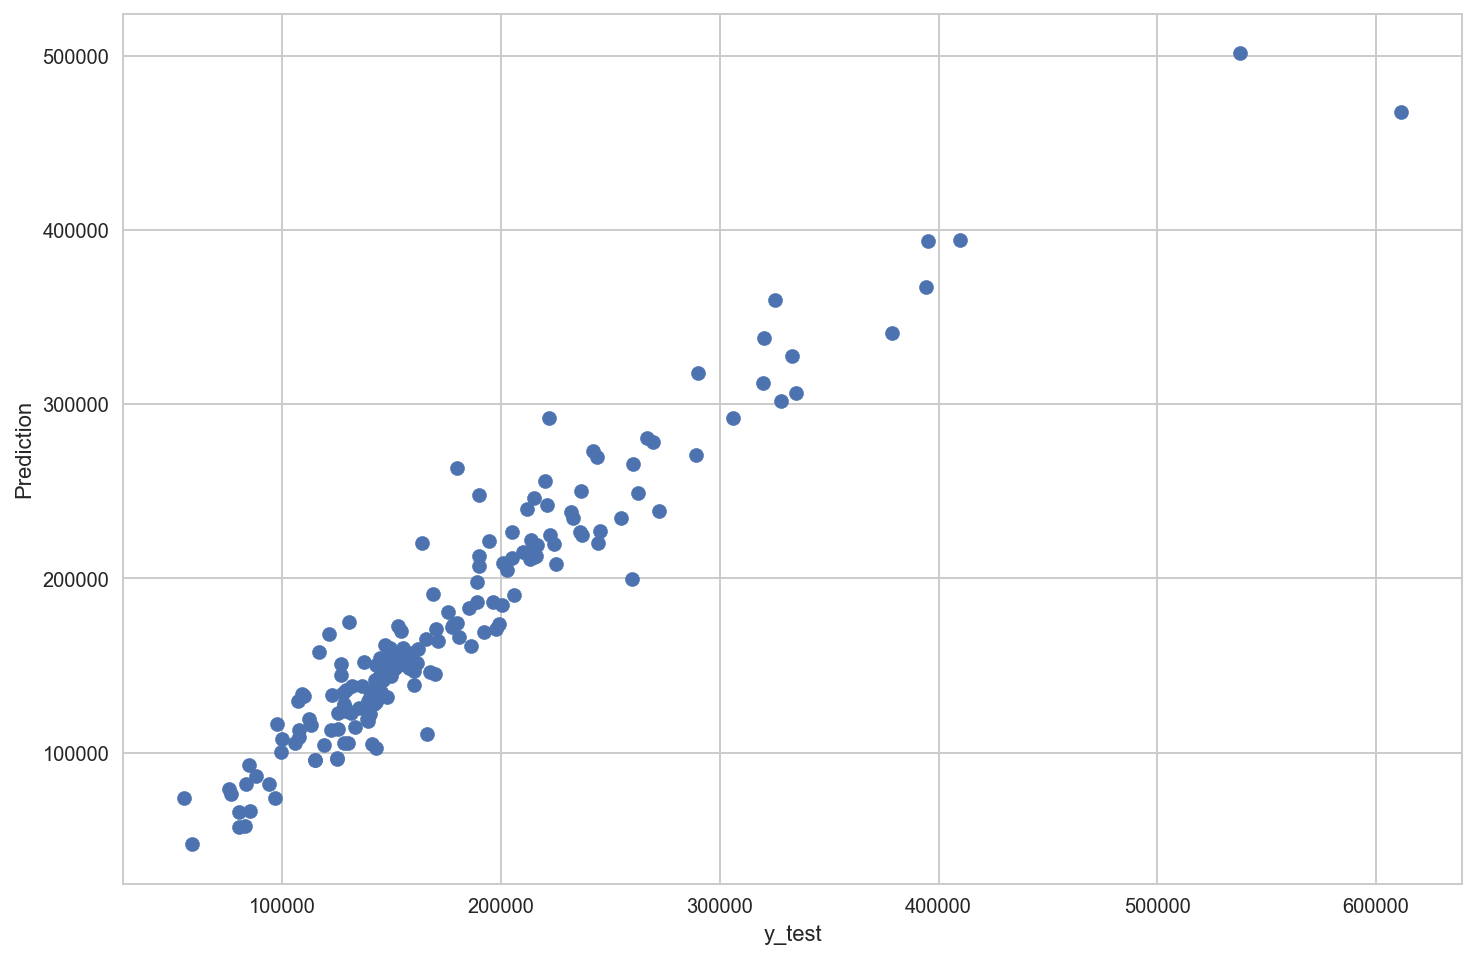

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(y_test,pred)

ax.set_xlabel('y_test')
ax.set_ylabel('Prediction')

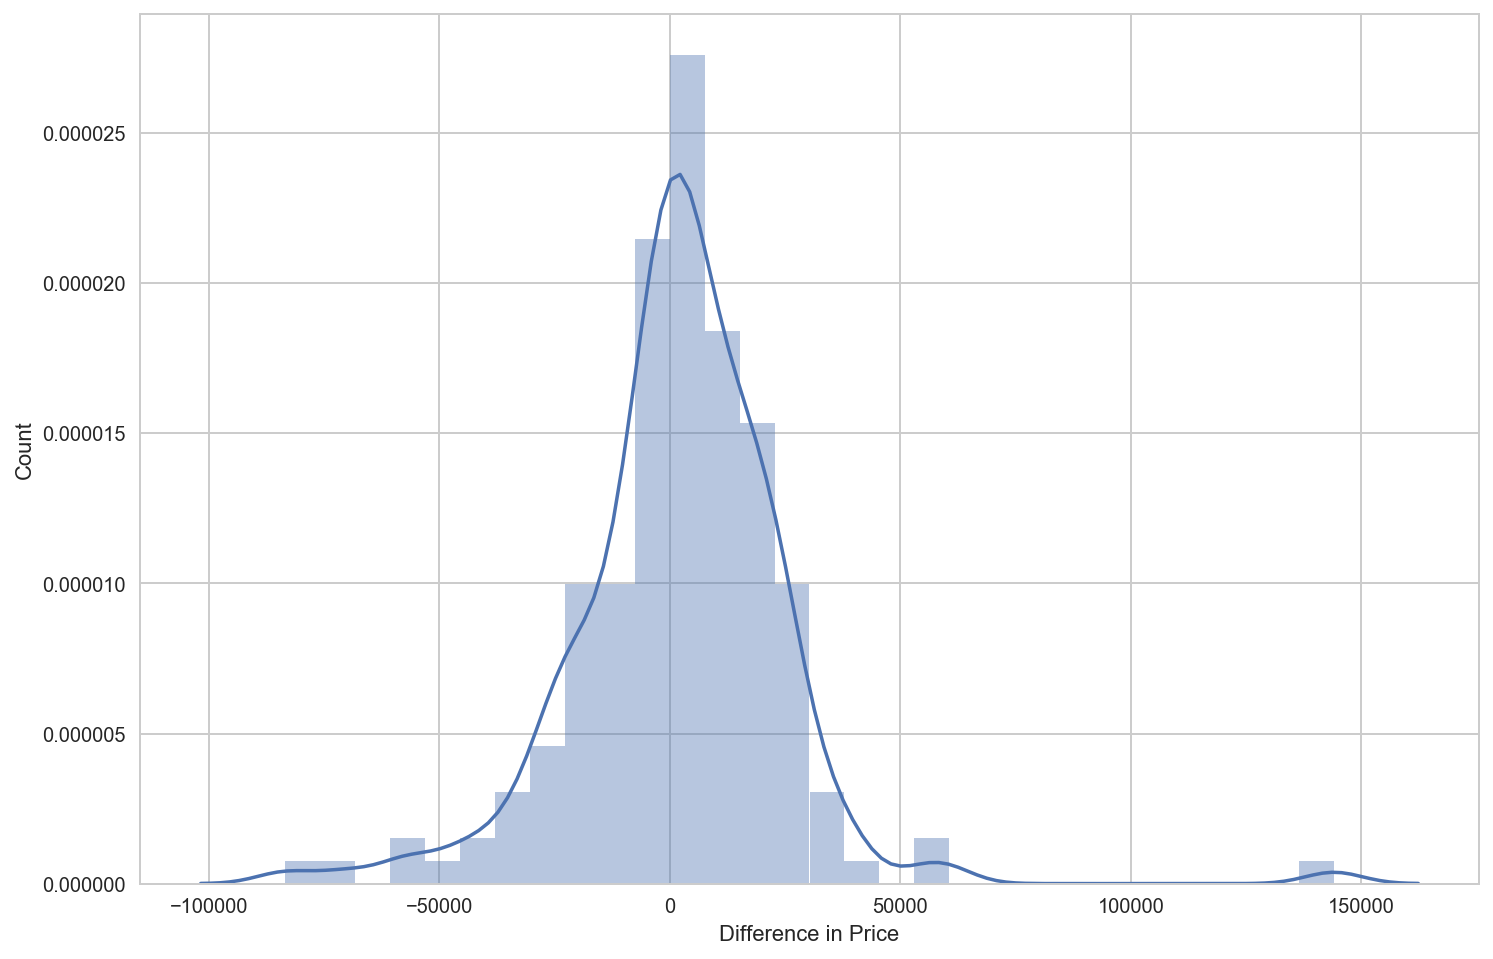

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot((y_test - pred))

ax.set_xlabel('Difference in Price')
ax.set_ylabel('Count')

In [53]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#cal metrics for linear regression
print 'Mean Abs Error : ', metrics.mean_absolute_error(y_test,pred), \
'Mean Sqr Error : ', metrics.mean_squared_error(y_test, pred)

#Linear Regression Score
print "Linear Regression Score : ", lr.score(Xt, y_test)

#cal Mean of ˆy
print 'ˆy Mean : ', np.mean(pred)

Mean Abs Error :  15882.9872453 Mean Sqr Error :  546903130.129
Linear Regression Score :  0.913973761701
ˆy Mean :  177174.410094


In [54]:
#cross val for linear regression

reg_score = cross_val_score(LinearRegression(), Xs, y_train, cv=5)
print 'Linear Regression Score : ', reg_score
print 'Linear Mean Score : ', np.mean(reg_score)


Linear Regression Score :  [ -1.30359178e+20  -1.82452970e+22  -1.63578948e+23  -1.79149776e+23
   9.12422819e-01]
Linear Mean Score :  -7.22208762146e+22


In [55]:
#Applying Lasso 
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

las = Lasso(alpha=120) #alpha at 120 by trial with (10, 100, 110, 120, 130, 140, ,150, 1000)
las.fit(Xs,y_train)

pred_las = las.predict(Xt)

print 'LASSO Score : ', las.score(Xt,y_test)

LASSO Score :  0.91623758634


In [56]:
#doing a cross val for Lasso
reg_score_las = cross_val_score(Lasso(), Xs, y_train, cv=5)
print 'Lasso Score : ', reg_score_las
print 'Lasso Mean Score : ', np.mean(reg_score_las)

/Users/Evan/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso Score :  [ 0.86680793  0.87315183  0.88614396  0.89189352  0.91261328]
Lasso Mean Score :  0.886122104412


In [57]:
#Applying Ridge 

ridge = Ridge(alpha=4) #alpha at 120 by trial with (0.1,0.5, 1, 2, 3, 4, 10, 100, 120, 1000)
ridge.fit(Xs,y_train)

pred_ridge = ridge.predict(Xt)

print 'LASSO Score : ', ridge.score(Xt,y_test)

LASSO Score :  0.914375903088


In [59]:
#doing a cross val for Ridge
reg_score_ridge = cross_val_score(Ridge(), Xs, y_train, cv=5)
print 'Ridge Score : ', reg_score_ridge
print 'Ridge Mean Score : ', np.mean(reg_score_ridge)

Ridge Score :  [ 0.8667865   0.87309819  0.89897218  0.89409099  0.91310788]
Ridge Mean Score :  0.889211147867


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [60]:
lr=LinearRegression()
pred_reno = lr.fit(Xs,y_train).predict(Xs)

In [61]:
reno_df.shape

(1448, 15)

In [62]:
feature_reno ="~"+" +".join([c for c in reno_df.columns if not c=="SalePrice"])+ " - 1"
print feature_reno

~Utilities +RoofStyle +RoofMatl +Exterior1st +Exterior2nd +ExterCond +Street +Alley +MasVnrType +Foundation +Heating +Electrical +PavedDrive +Fence +MiscFeature - 1


In [63]:
X_reno = patsy.dmatrix(feature_reno, data=reno_df, return_type ="dataframe")
X_reno.head ()

,Utilities[AllPub],Utilities[NoSeWa],RoofStyle[T.Gable],RoofStyle[T.Gambrel],RoofStyle[T.Hip],RoofStyle[T.Mansard],RoofStyle[T.Shed],RoofMatl[T.Membran],RoofMatl[T.Metal],RoofMatl[T.Roll],...,PavedDrive[T.P],PavedDrive[T.Y],Fence[T.GdWo],Fence[T.MnPrv],Fence[T.MnWw],Fence[T.None],MiscFeature[T.None],MiscFeature[T.Othr],MiscFeature[T.Shed],MiscFeature[T.TenC]
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [64]:
#splitting of test and train set
X_train_reno = X[X['YrSold']!=2010]
X_test_reno = X[X['YrSold'] == 2010]

In [65]:
#checking of their shape to make sure that model can be run without error
X_train_reno.shape, X_test_reno.shape

((1276, 184), (172, 184))

In [67]:
#Scaling of the data
scaler = StandardScaler().fit(X_train_reno)
Xs_reno = scaler.transform(X_train_reno)
Xt_reno = scaler.transform(X_test_reno)

In [68]:
# Residual for Y_train and Y_test
Res_ytrain =(pred_reno - y_train)
Res_ytest=(pred - y_test)

In [69]:
# Linear Regression for Renovatable
lr_reno=LinearRegression()
pred_reno=lr_reno.fit(Xs_reno,Res_ytrain).predict(Xt_reno)

print lr_reno.score(Xt_reno,Res_ytest)

-0.00729560376449


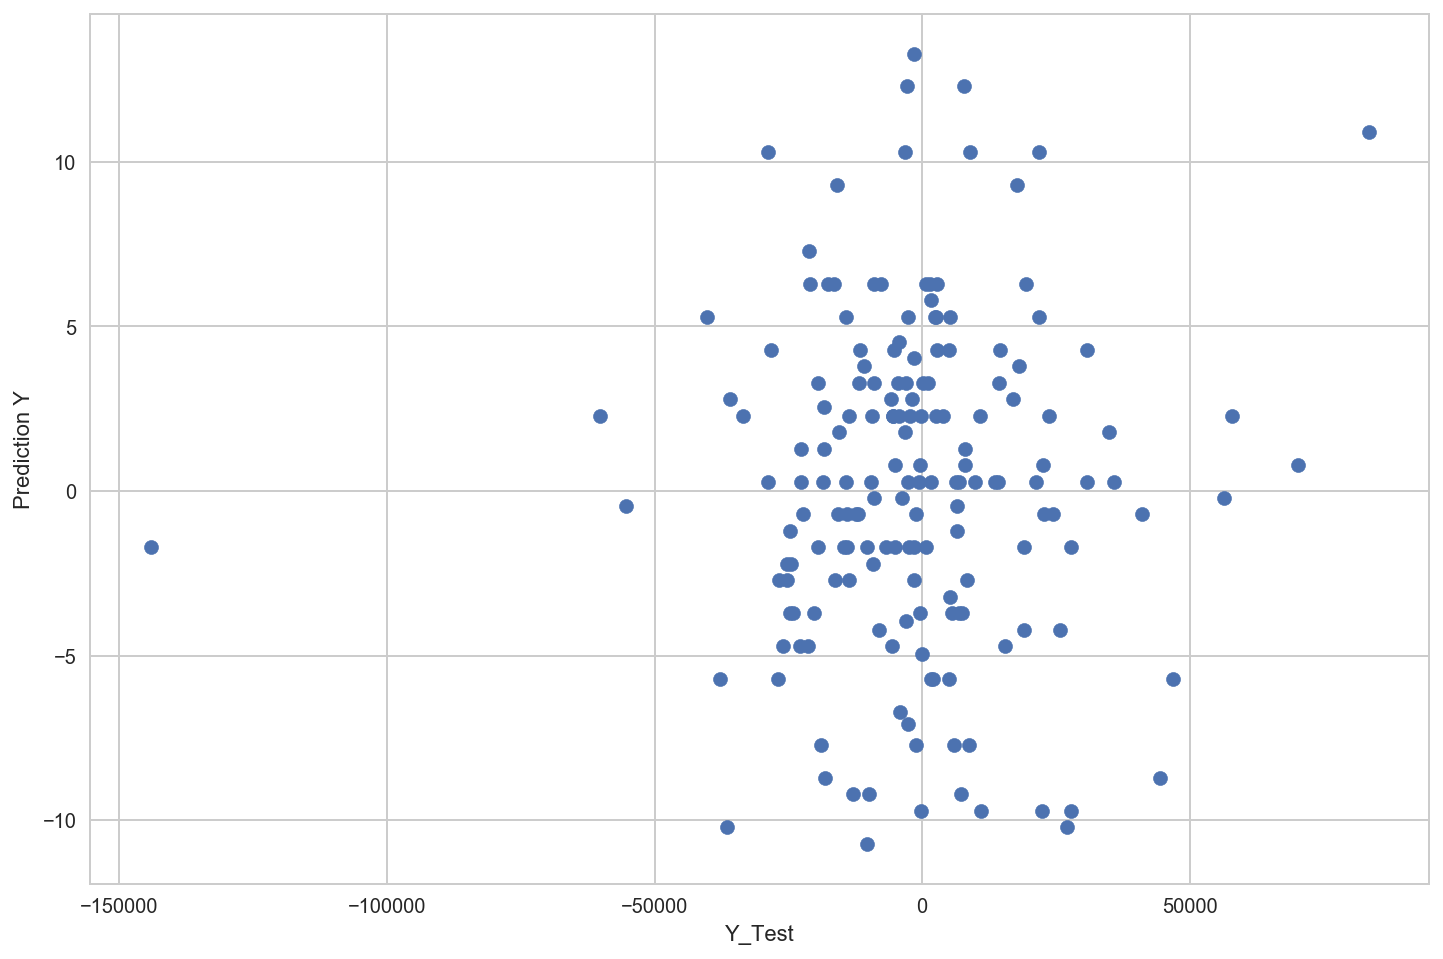

In [70]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(Res_ytest,pred_reno)

# Customization scale and label
ax.set_xlabel ("Y_Test")
ax.set_ylabel ("Prediction Y")

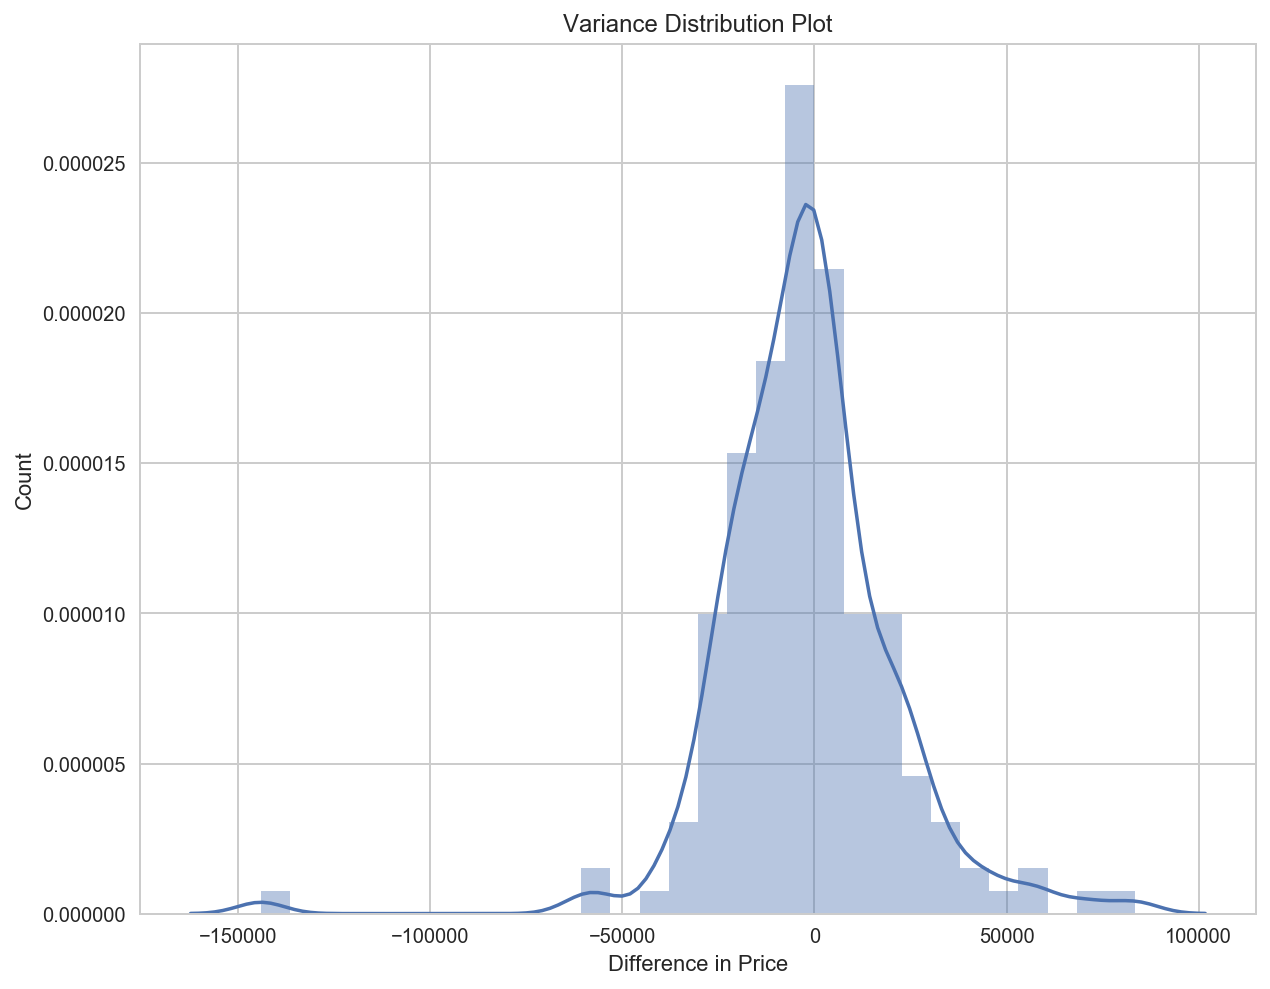

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot((Res_ytest - pred_reno))

ax.set_title("Variance Distribution Plot")
ax.set_xlabel ("Difference in Price")
ax.set_ylabel ("Count")

In [73]:
print metrics.mean_absolute_error(Res_ytest,pred_reno)
print metrics.mean_squared_error(Res_ytest, pred_reno)
print np.sqrt(metrics.mean_squared_error(Res_ytest, pred_reno))
print np.std(Res_ytest)
print np.mean(Res_ytest)

15882.8846403
546893737.558
23385.7592898
23300.9166256
-1992.58990625


In [97]:
# LASSO Regression for Renovatable

las_reno = Lasso(alpha=10)
pred_las_reno = las_reno.fit(Xs_reno, Res_ytrain).predict(Xt_reno)

print las_reno.score(Xt_reno,Res_ytest)

-0.00731126457287


In [98]:
# RIDGE REgression for renovatable

Rig_reno = Ridge(alpha=10)
pred_rig_reno = Rig_reno.fit(Xs_reno, Res_ytrain).predict(Xt_reno)

print Rig_reno.score(Xt_reno, Res_ytest)

-0.00747673243192


In [ ]:
#Both model performs worse than the baseline. I would not suggest using them after running them.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [99]:
house.SaleCondition.value_counts()

Normal     1194
Partial     123
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [105]:
#convert abnormal to 1 and none to 0
abnorm = house.SaleCondition.map(lambda x: 1 if x == 'Abnorml' else 0)
abnorm.value_counts(dropna=False)

0    1352
1      96
Name: SaleCondition, dtype: int64

In [107]:
feature_abnorm=" SaleCondition ~ "+" +".join([c for c in house.columns if not c=="SaleCondition"])+"-1"
print feature_abnorm

 SaleCondition ~ Id +MSSubClass +MSZoning +LotFrontage +LotArea +Street +Alley +LotShape +LandContour +Utilities +LotConfig +LandSlope +Neighborhood +Condition1 +Condition2 +BldgType +HouseStyle +OverallQual +OverallCond +YearBuilt +YearRemodAdd +RoofStyle +RoofMatl +Exterior1st +Exterior2nd +MasVnrType +MasVnrArea +ExterQual +ExterCond +Foundation +BsmtQual +BsmtCond +BsmtExposure +BsmtFinType1 +BsmtFinSF1 +BsmtFinType2 +BsmtFinSF2 +BsmtUnfSF +TotalBsmtSF +Heating +HeatingQC +CentralAir +Electrical +FirstFlrSF +SecFlrSF +LowQualFinSF +GrLivArea +BsmtFullBath +BsmtHalfBath +FullBath +HalfBath +BedroomAbvGr +KitchenAbvGr +KitchenQual +TotRmsAbvGrd +Functional +Fireplaces +FireplaceQu +GarageType +GarageYrBlt +GarageFinish +GarageCars +GarageArea +GarageQual +GarageCond +PavedDrive +WoodDeckSF +OpenPorchSF +EnclosedPorch +ThreeSsnPorch +ScreenPorch +PoolArea +PoolQC +Fence +MiscFeature +MiscVal +MoSold +YrSold +SaleType +SalePrice-1


In [109]:
import patsy

y_abnorm,X_abnorm = patsy.dmatrices (feature_abnorm, data=house, return_type ="dataframe")
y_abnorm = y_abnorm.values.ravel()

In [110]:
from sklearn.model_selection import train_test_split

X_abtrain, X_abtest, y_abtrain, y_abtest = train_test_split(X_abnorm, y_abnorm, test_size=0.33, random_state=10)

ValueError: Found input variables with inconsistent numbers of samples: [1448, 8688]